In [1]:
import numpy as np
from scipy.signal import fftconvolve
from scipy.stats import multivariate_normal
from skimage import restoration
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
from torchvision import datasets
import train_agent as ta

In [2]:
device = 'cuda:0'
seed = 0
test_blur = 'random'
#test_blur = 'random'
num_blur = 3

In [3]:
# kernels
std = 3.0
f = np.vectorize(lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y]))
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
kernel1 = f(X, Y)
kernel1 = kernel1 / kernel1.sum()
np.random.seed(0)
kernel2 = np.random.rand(*kernel1.shape)
kernel2 = kernel2 / kernel2.sum()

# filters
filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel1, mode='same')))
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel2, mode='same')))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel1, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel2, 1e-2)))
filt_names = ['None', 'Blur1', 'Blur2', 'Wiener1', 'Wiener2']

# images
# data = datasets.MNIST(root='./data', train=True, download=True)
data = datasets.MNIST(root='./data', train=False, download=True)
np.random.seed(seed)
# idx = np.random.choice(data.data.shape[0], 2000)
# imgs = data.data[idx].numpy() / 255
imgs = data.data.numpy() / 255
if test_blur == 'gauss':
    blurred_imgs = np.stack(list(map(lambda x: ta.blur(x, kernel1, c=num_blur), imgs)), axis=0)
    filt_inv = filt[3]
elif test_blur == 'random':
    blurred_imgs = np.stack(list(map(lambda x: ta.blur(x, kernel2, c=num_blur), imgs)), axis=0)
    filt_inv = filt[4]
imgs = torch.from_numpy(imgs).to(torch.float)
blurred_imgs = torch.from_numpy(blurred_imgs).to(torch.float)

In [4]:
# 加藤テストデータを読み込む。
# これをblurred_imgs, imgsと照らし合わせる
context = np.load('data/GR3.0/test/random/c3_dataset.npz')
Dy = context['test_dataset']
Dx = context['original_dataset']

print(np.allclose(Dy, blurred_imgs))
print(np.allclose(Dx, imgs))

True
True


In [5]:
def get_img(imgs, blurred_imgs, i, channel=1):
    y, x = imgs[[i]], blurred_imgs[[i]]
    if channel == 1:
        x = x.unsqueeze(0)
    elif channel == 2:
        x = torch.cat([x, x], dim=0).unsqueeze(0)
    return (x, y.unsqueeze(0))

In [6]:
# MSE of initial images
torch.mean((blurred_imgs - imgs)**2).item()

0.046024732291698456

In [7]:
# MSE of fixed corresponding filter
with torch.no_grad():
    err = []
    for i in tqdm(range(imgs.shape[0])):
        s = get_img(imgs, blurred_imgs, i, channel=2)
        for j in range(5):
            x, y = s
            if j < num_blur:
                x[0, 0, :, :] = torch.tensor(filt_inv(x[0, 0, :, :].numpy()))
                s_next = (x, y)
            else:
                s_next = s
            r = ta.reward(s, s_next, 0)
            s = s_next
        err.append(torch.mean((s[0][0, 0] - s[1][0, 0])**2).item())
print(np.mean(err), np.std(err))


0.01962356203519739 0.00718379020428755


In [8]:
test_blur

'random'

In [9]:
# MSE of agent
Qnet = ta.MnistNet(c=2, m=[20, 20, len(filt)])
Qnet.load_state_dict(torch.load('./Qnet020000.pth', map_location=torch.device('cpu')))
Qnet = Qnet.to(device)

with torch.no_grad():
    err = []
    count = np.zeros((len(filt), 5))
    for i in tqdm(range(imgs.shape[0])):
        s = get_img(imgs, blurred_imgs, i, channel=2)
        for j in range(5):
            x, y = s
            q = Qnet(x.to(device))
            q = q[0].to('cpu').numpy()
            a = np.argmax(q)
            s_next = ta.next_state(s, a, filt, channel=2)
            r = ta.reward(s, s_next, a)
            s = s_next
            count[a, j] = count[a, j] + 1
        err.append(torch.mean((s[0][0, 0] - s[1][0, 0])**2).item())
print(np.mean(err), np.std(err))


0.021505156240612267 0.008252542286371371


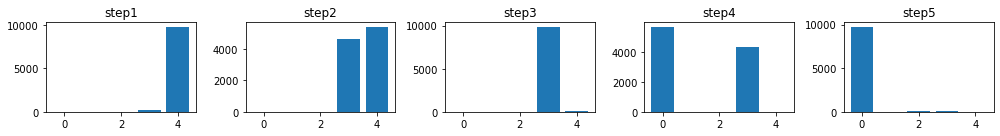

In [34]:
plt.figure(figsize=(14, 2))
for j in range(5):
    plt.subplot(1, 5, j+1)
    plt.bar(range(len(filt)), count[:, j])
    plt.title('step%d' % (j+1,))
plt.tight_layout()
plt.show()

In [10]:
import sys
import os
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, Agent, agent_metrics, show_reward, settings
### path load

In [11]:
# MSE of agent
Qnet = ta.MnistNet(c=2, m=[20, 20, len(filt)])
Qnet.load_state_dict(torch.load('./Qnet020000.pth', map_location=torch.device('cpu')))
# Qnet = Qnet.to(device)


def satohara_metric(Qnet, blurred_imgs, imgs):
    with torch.no_grad():
        err = []
        count = np.zeros((len(filt), 5))
        res = []
        for i in tqdm(range(imgs.shape[0])):
            s = get_img(imgs, blurred_imgs, i, channel=2)
            for j in range(5):
                x, y = s
                q = Qnet(x)
                q = q[0].to('cpu').numpy()
                a = np.argmax(q)
                s_next = ta.next_state(s, a, filt, channel=2)
                s = s_next
                count[a, j] = count[a, j] + 1
            err.append(torch.mean((s[0][0, 0] - s[1][0, 0])**2).item())
            res.append(s[0][0, 0].numpy())
    print(np.mean(err), np.std(err))
    print(type(s[0][0, 0]))
    return np.array(res)

def agent_output(Qnet, Dy, Dx, filt):
    agent = Agent(Qnet, filt, 2)
    out = []
    for n in range(Dy.shape[0]):
        yn = Dy[n]
        yn, _ = agent(yn)
        out.append(yn.numpy())
    return np.array(out)

# 3種類のフィルタ
context = np.load('data/GR3.0/test/random/c3_dataset.npz')
Dy = torch.from_numpy(context['test_dataset']).to(torch.float)
Dx = torch.from_numpy(context['original_dataset']).to(torch.float)

# a = 3
# i = 4
# s = get_img(Dx, Dy, i, channel=2)
# next_state = ta.next_state(s, a, filt, channel=2)
# print(next_state[0].shape)

out_satohara = satohara_metric(Qnet, Dy, Dx)
print(out_satohara.shape)
# kato

def agent_next(s, a, Qnet, actions):
    z, y = s.squeeze(0)
    z = z.cpu().numpy()
    z_next = actions[a](z)
    z_next = torch.from_numpy(z_next).to(torch.float)
    return torch.stack([z_next, y]).unsqueeze(0)

# out = agent_next(s[0], a, Qnet, filt)
# print(out.shape)
# print(np.allclose(out.numpy(), next_state[0].numpy()))

out_kato = agent_output(Qnet, Dy, Dx, filt)
print('agent', out_kato.shape)
np.allclose(out_kato, out_satohara)


0.021505096565838905 0.00825363370084882
<class 'torch.Tensor'>
(10000, 28, 28)
agent (10000, 28, 28)


True

In [19]:
result = agent_metrics(Dy, Dx, Qnet, filt, channel=2)
result[:, -1].mean()

100%|██████████| 10000/10000 [01:19<00:00, 125.94it/s]


0.021505096565838905